This file is copied from

https://gluon-cv.mxnet.io/build/examples_action_recognition/dive_deep_i3d_kinetics400.html

and modified to be used on the UCF101 dataset.

In [1]:
%matplotlib inline

4. Dive Deep into Training I3D mdoels on UCF101
=======================================================

This is a video action recognition tutorial using Gluon CV toolkit, a step-by-step example.
The readers should have basic knowledge of deep learning and should be familiar with Gluon API.
New users may first go through `A 60-minute Gluon Crash Course <http://gluon-crash-course.mxnet.io/>`_.
You can `Start Training Now`_ or `Dive into Deep`_.

Start Training Now
~~~~~~~~~~~~~~~~~~


Network Structure
-----------------

First, let's import the necessary libraries into python.


In [2]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import UCF101
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

Here we pick a widely adopted model, ``I3D-InceptionV1``, for the tutorial.
`I3D <https://arxiv.org/abs/1705.07750>`_ (Inflated 3D Networks) is a widely adopted 3D video
classification network. It uses 3D convolution to learn spatiotemporal information directly from videos.
I3D is proposed to improve C3D model by inflating from 2D models.
We can not only reuse the 2D models' architecture (e.g., ResNet, Inception), but also bootstrap
the model weights from 2D pretrained models. In this manner, training 3D networks for video
classification is feasible and getting much better results.



In [3]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

# Get the model i3d_resnet50_v1_ucf101 with 101 output classes, without pre-trained weights
net = get_model(name='i3d_resnet50_v1_ucf101', nclass=101)
net.collect_params().reset_ctx(ctx)
print(net)

conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  (64,)
batchnorm0_beta is done with shape:  (64,)
batchnorm0_running_mean is done with shape:  (64,)
batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

Data Augmentation and Data Loader
---------------------------------

Data augmentation for video is different from image. For example, if you
want to randomly crop a video sequence, you need to make sure all the video
frames in this sequence undergo the same cropping process. We provide a
new set of transformation functions, working with multiple images.
Please checkout the `video.py <../../../gluoncv/data/transforms/video.py>`_ for more details.
Most video data augmentation strategies used here are introduced in [Wang15]_.



In [4]:
transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66]),
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

With the transform functions, we can define data loaders for our
training datasets.



In [5]:
# Batch Size for Each GPU
per_device_batch_size = 5
# Number of data loader workers
num_workers = 1
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training the model.
# ``new_length`` indicates the number of frames we use as input.
# ``new_step`` indicates we skip one frame to sample the input data.
train_dataset = UCF101(train=True, new_length=32, new_step=2, transform=transform_train)
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 9537 training samples.


Optimizer, Loss and Metric
--------------------------



In [6]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [30, 55, 70, np.inf]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.01, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In order to optimize our model, we need a loss function.
For classification tasks, we usually use softmax cross entropy as the
loss function.



In [7]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

For simplicity, we use accuracy as the metric to monitor our training
process. Besides, we record metric values, and will print them at the
end of training.



In [8]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

Training
--------

After all the preparations, we can finally start training!
Following is the script.

<div class="alert alert-info"><h4>Note</h4><p>In order to finish the tutorial quickly, we only train for 3 epochs on a tiny subset of UCF101,
  and 100 iterations per epoch. In your experiments, we recommend setting ``epochs=100`` for the full UCF101 dataset.</p></div>



.........................................................................................................................................................................................................|
[Epoch 0] train=0.108458 loss=4.251682 time: 191.863132
.........................................................................................................................................................................................................|
[Epoch 1] train=0.105473 loss=4.081599 time: 175.502793
.........................................................................................................................................................................................................|
[Epoch 2] train=0.155224 loss=3.703812 time: 170.540126
.........................................................................................................................................................................................................|
[Epoch 3] train=0.16

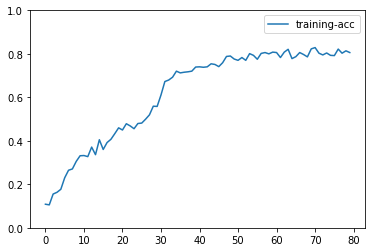

In [9]:
epochs = 80
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        new_lr = trainer.learning_rate*lr_decay
        trainer.set_learning_rate(new_lr)
        print("New learning rate: ", new_lr)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        print(".", end="")
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 200:
            print("|")
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()


References
----------

.. Joao Carreira and Andrew Zisserman. “Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset.” In Computer Vision and Pattern Recognition (CVPR), 2017.

